# Profiling GPU usage on Google Colab

This notebook will walk you through how to correctly (as of August 2022) install/configure everything you need to be able to run GPU profiling on Google Colab.

**Note that this does not allow you to profile code running in the notebook's cells directly!**: The code you want to profile will need to be stored in regular python files. This is still useful if Colab is your main source of GPUs.

**Make sure you are using a GPU runtime**: Runtime -> Change Runtime Type

## Installing NVIDIA's dependencies

Install NVIDIA custom python package index and then DLProf + DLProfViewer.

DLProf will profile our application, gather metrics and save them in a database file.  Note: If you are using tensorflow instead of pytorch, install `nvidia-dlprof[tensorflow]` instead.
DLProfViewer will allow us to explore the metrics through a web dashboard.


* [DLProf documentation](https://docs.nvidia.com/deeplearning/frameworks/dlprof-user-guide/index.html)
* [DLProfViewer documentation](https://docs.nvidia.com/deeplearning/frameworks/tensorboard-plugin-user-guide/index.html)

In [1]:
%%capture
!pip install nvidia-pyindex
!pip install nvidia-dlprof nvidia-dlprof[pytorch] nvidia-dlprofviewer 

Delete all existing binaries of NVIDIA Nsight and reinstall latest version

In [2]:
%%capture
!rm /usr/local/bin/nsys
!rm /usr/local/cuda/bin/nsys 
!wget https://developer.download.nvidia.com/devtools/repos/ubuntu1804/amd64/NsightSystems-linux-cli-public-2022.2.1.31-5fe97ab.deb
!dpkg -i NsightSystems-linux-cli-public-2022.2.1.31-5fe97ab.deb

### Tunneling to access DLProf Dashboard

The only way I was able to access DLProfViewer was through tunnelling, so we are going to use [localtunnel](https://github.com/localtunnel/localtunnel) to expose DLProfViewer's dashboard externally.

In [3]:
%%capture
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.95s


### Sample CUDA Program

A simple program running some matmuls to generate some CUDA events to monitor.  
Note the two lines:
```python
import nvidia_dlprof_pytorch_nvtx
nvidia_dlprof_pytorch_nvtx.init()
```
and later, the use of NVTX context manager:
```python
with torch.autograd.profiler.emit_nvtx():
```

Those are required to tell PyTorch to actually emit NVTX events.
*italicized text*

In [4]:
%%writefile sample.py
import torch
import nvidia_dlprof_pytorch_nvtx
nvidia_dlprof_pytorch_nvtx.init()

def main():
  a = torch.rand((1024, 1024), device='cuda')
  b = torch.rand((1024, 1024), device='cuda')
  for _ in range(128):
    a.matmul(b)
  print('done')

if __name__ == '__main__':
  with torch.autograd.profiler.emit_nvtx():
    main()

Writing sample.py


### Profiling our code

To have DLProf actually profile our code, we need to launch our python program with DLProf's binary.


In [5]:
!dlprof --mode pytorch --output_path=./dlprof python sample.py

[DLProf-18:37:19] Creating Nsys Scheduler
[DLProf-18:37:19] RUNNING: nsys profile -t cuda,nvtx -s none --show-output=true --export=sqlite -o ./dlprof/nsys_profile python sample.py
Initializing NVTX monkey patches
Done with NVTX monkey patching
done
/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:182: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "
Generating '/tmp/nsys-report-3297.qdstrm'
[1/2] [========================100%] nsys_profile.nsys-rep
[2/2] [========================100%] nsys_profile.sqlite
Generated:
    /content/./dlprof/nsys_profile.nsys-rep
    /content/./dlprof/nsys_profile.sqlite
[DLProf-18:37:31] DLprof completed system call successfully
[DLProf-18:37:32] Initializing Nsight Systems database
[DLProf-18:37:32] Reading System Information from Nsight Systems database
[DLProf-18:37:32] Reading Domains from Nsight Systems database
[

### Launching localtunnel + NVProfViewer

Now, we need to launch two servers:
* DLProfViewer to launch the dashboard
* localtunnel to forward our dashboard to the external word

Since both of those processes will be running forever, we can't start them both from a cell using the `!` magic command.

If you have Colab Pro, you can use the terminal to launch localtunnel, but if you don't, you can use the xterm extension for colab. This will allow you to launch a terminal directly as a cell and from there keep localtunnel running without blocking your notebook. 

**Whatever method you choose, in the terminal, launch localtunnel with the following command:**

```bash
lt --port 8000
```

This will display the tunnel's url (something like https://hungry-windows-cross-35-204-194-225.loca.lt) that we will need in the next step.

**Keep that terminal alive for as long as you will need to access the dashboard** *italicized text*

In [27]:
!pip install colab-xterm
%load_ext colabxterm
%xterm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm


Launching Xterm...

<IPython.core.display.Javascript object>

Now, we will actually launch DLProfViewer on the port forwarded by localtunnel (8000 in our case).

This cell will block your notebook, so you'll need to kill it once you are done before you can do anything else. You could also run it in the terminal instead like we have done above with localtunnel if for some reason you want to keep the dashboard alive while you use the notebook.

In [ ]:
!dlprofviewer --port 8000 ./dlprof/dlprof_dldb.sqlite

[dlprofviewer-06:54:33 PM UTC] dlprofviewer running at http://localhost:8000


Finally, navigate to the url you got when launching localtunnel and you should see DLProfViewer's dashboard with the (abysmal) GPU usage informations from our sample program.

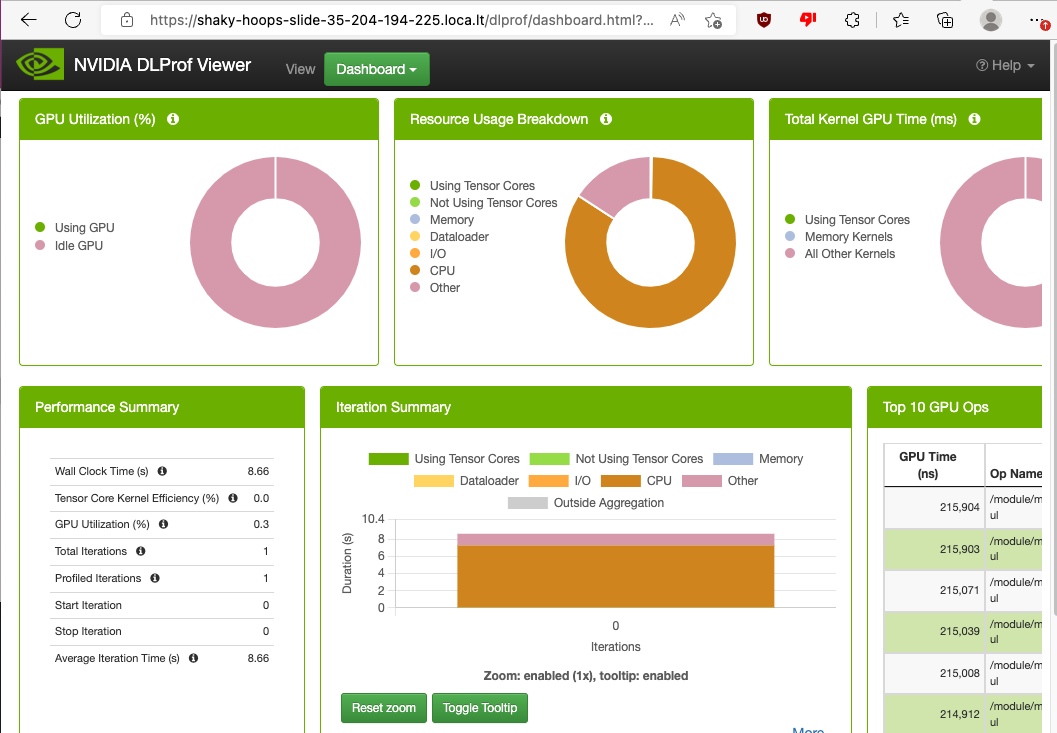